In [26]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [27]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [28]:
from tqdm.auto import tqdm

In [29]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

# Binary Synthetic Data

In [21]:
from kcmc.data_binary import evaluate_policy, generate_data, estimate_p_t

In [22]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

In [23]:
# Guessing kernel with approximate solution
Y, T, X, _, _, _ = generate_data(1000)
p_t = estimate_p_t(X, T)
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, Gamma=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

#### Define a trainable policy

In [24]:
def LR_policy(X, T, beta):
    n = X.shape[0]
    T = torch.as_tensor(T)
    X = np.concatenate([np.ones([n, 1]), X], axis=1)
    p = torch.sigmoid(torch.tensor(X) @ beta)
    return (1 - T) * p + T * (1 - p)

### Experiment of Policy Learning Curve

In [25]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        tan_box_const=True,
    ),
}

In [16]:
import csv
import os.path
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from kcmc.estimators import confounding_robust_estimator


EXAMPLE_PARAMS = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS

def run_policy_learning_experiment(
    log_file, params, data_type='synthetic binary', sample_size=500, n_seeds=1, seed0=0, n_steps=201, log_info="",
):
    assert data_type in ['synthetic binary', 'synthetic continuous', 'real binary']
    assert set(params.keys()) == set(EXAMPLE_PARAMS.keys())
    print(f"Policy learning with {log_info}...")
    for seed in range(seed0, seed0 + n_seeds):
        Y, T, X, p_t = get_data(data_type, sample_size, seed)
        beta = torch.zeros(6, requires_grad=True, dtype=float)
        logistic_policy = lambda X, T: LR_policy(X, T, beta)
        optimizer = torch.optim.SGD(lr=1e-1, params=[beta])
        pbar = tqdm(range(n_steps))
        for i in pbar:
            lower_bound = confounding_robust_estimator(Y, T, X, p_t, logistic_policy, **params)
            np.random.seed(0)
            ground_truth = evaluate_policy(logistic_policy, n=100000)
            (- lower_bound).backward()
            optimizer.step()
            optimizer.zero_grad()
            lower_bound, ground_truth = map(lambda x: x.data.numpy(), (lower_bound, ground_truth))
            log_csv(log_file, data_type, 'logistic policy', lower_bound, ground_truth, params, sample_size, seed, log_info, i)
            pbar.set_description(f"Seed: {seed},\tTrain lower bound: {lower_bound}")
            
        pbar = tqdm(range(10))
        for seed in pbar:
            np.random.seed(seed)
            Y, T, X, _, _, _ = generate_data(5000)
            p_t = estimate_p_t(X, T)
            params['D'] = 250
            params['hard_kernel_const'] = True
            test_lower_bound = confounding_robust_estimator(Y, T, X, p_t, logistic_policy, **params).data.numpy()
            p_t = estimate_p_t(X, T)
            log_csv(log_file, data_type, 'logistic policy', test_lower_bound, -1, params, 5000, seed, log_info+"_test", i)
            pbar.set_description(f"Seed: {seed},\tTest lower bound: {test_lower_bound}")


def get_data(data_type, sample_size, seed):
    if 'synthetic' in data_type:
        if 'binary' in data_type:
            from kcmc.data_binary import generate_data, evaluate_policy, estimate_p_t
        elif 'continuous' in data_type:
            from kcmc.data_continuous import generate_data, evaluate_policy, estimate_p_t
        else:
            raise ValueError
        np.random.seed(seed)
        Y, T, X, U, e_x, e_xu = generate_data(sample_size)
        p_t = estimate_p_t(X, T)
    elif 'real' in data_type:
        from kcmc.data_real import generate_data, estimate_p_t
        Y, T, X = generate_data()
        p_t = estimate_p_t(X, T)
    return Y, T, X, p_t

def log_csv(log_file, data_type, policy_name, lower_bound, ground_truth, params, sample_size, seed, log_info, step):
    if not os.path.exists(log_file):
        # make a column name
        columns = ['log_info', 'data_type', 'policy_name', 'sample_size', 'seed', 'step', 'lower_bound', 'ground_truth', *params.keys()]
        with open(log_file, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(columns)
    # log data by appending to the csv file
    fields=[log_info, data_type, policy_name, sample_size, seed, step, lower_bound, ground_truth, *params.values()]
    with open(log_file, 'a') as file:
        writer = csv.writer(file)
        writer.writerow(fields)
                                      

In [ ]:
log_file='logs/policy_learning_synthetic_binary_curve.csv'

for method_name, params in grid_methods.items():
    run_policy_learning_experiment(
        log_file, params, data_type='synthetic binary', 
        n_seeds=10, sample_size=500, log_info=method_name
    )

Policy learning with GP_KCMC...


  0%|          | 0/201 [00:00<?, ?it/s]

In [12]:
df = pd.read_csv('logs/policy_learning_synthetic_binary_curve.csv')

In [13]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,step,lower_bound,ground_truth,D,lambd,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,logistic policy,500,0,0,3.576791,3.745165,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
1,ZSB,synthetic binary,logistic policy,500,0,1,3.667312,3.802417,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
2,ZSB,synthetic binary,logistic policy,500,0,2,3.750215,3.855805,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
3,ZSB,synthetic binary,logistic policy,500,0,3,3.818935,3.901866,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
4,ZSB,synthetic binary,logistic policy,500,0,4,3.876666,3.941502,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False


In [10]:
#df = df.iloc[266:, :]

In [14]:
df.groupby(by="log_info").count()

,data_type,policy_name,sample_size,seed,step,lower_bound,ground_truth,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
log_info,,,,,,,,,,,,,,,,,,,,,
GP_KCMC,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
GP_KCMC_test,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
ZSB,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
ZSB_test,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
hard_KCMC,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
hard_KCMC_test,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [15]:
df_grouped = df.groupby(by=['log_info', 'step'])['lower_bound', 'ground_truth']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1951155/1088673318.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'step'])['lower_bound', 'ground_truth']


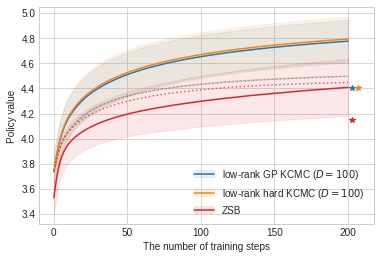

In [30]:
steps = sorted(df.step.unique())
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
colors["ZSB"] = tab10((0.5 + 3) / 10)
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "low-rank hard KCMC ($D=100$)", "ZSB"]

for method_name in grid_methods.keys():
    lower = np.array([values_mean.loc[(method_name, i)]['lower_bound'] for i in steps])
    dlower = np.array([values_std.loc[(method_name, i)]['lower_bound'] for i in steps])
    test_lower = values_mean.loc[(method_name + '_test', max(steps))]['lower_bound']
    gt = np.array([values_mean.loc[(method_name, i)]['ground_truth'] for i in steps])
    # dtest_lower = values_std.loc[(method + '_test', max(steps))]['lower_bound']
    c = colors[method_name]
    lower_line = plt.plot(steps, lower, c=c)[0]
    lower_band = plt.fill_between(steps, lower + dlower, lower - dlower, color=c, alpha=0.1)
    #test_lower_line = plt.plot(steps[shifted_slice], [test_lower for _ in steps[shifted_slice]], '-', c=c, alpha=0.2)[0]
    test_lower_line = plt.plot(steps[-1] + (7 if 'hard' in method_name else 3), [test_lower], '*', c=c)[0]
    shifted_slice = slice(1, len(steps)) if 'hard' in method_name else slice(len(steps))
    gt_line = plt.plot(steps[shifted_slice], gt[shifted_slice], ':', c=c, alpha=0.7)[0]
    legend_targets.append((lower_line, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"The number of training steps")
plt.ylabel(r"Policy value")
plt.savefig('logs/policy_learning_synthetic_binary_curve.pdf')

In [80]:
df[df.step==200].head()

,log_info,data_type,policy_name,sample_size,seed,step,lower_bound,ground_truth,D,lambd,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
265,ZSB,synthetic binary,logistic policy,500,0,200,4.705517,4.453796,200,1.5,...,False,True,total variation,True,False,False,False,True,False,False
466,ZSB,synthetic binary,logistic policy,500,0,200,4.705517,4.453796,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
467,ZSB_test,synthetic binary,logistic policy,500,0,200,4.255855,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
468,ZSB_test,synthetic binary,logistic policy,500,1,200,4.187823,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
469,ZSB_test,synthetic binary,logistic policy,500,2,200,4.074019,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False


#### The interpretation of the above plot:
- Since the upper/lower bound's tightness is independent of the sample size by definition, the width of interval should not change significantly for different sample size
- However, the 

#### Best Policy

In [ ]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X, T: LR_policy(X, T, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

  0%|          | 0/101 [00:00<?, ?it/s]

### Just run min-max optimzation

In [ ]:
def evaluate_confounding_robust_hajek(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        Gamma=1.5, hajek_const=True, tan_box_const=True,
    )
    return est

In [ ]:
def evaluate_confounding_robust_kernel(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        D=200, Gamma=1.5, alpha=0.05, 
        sigma2=sigma2, kernel=kernel,
        kernel_const=True,
        tan_box_const=True,
    )
    return est

In [ ]:
# Hajek policy min-max value
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X, T: LR_policy(X, T, beta_hajek)
optimizer = torch.optim.SGD(lr=1e-1, params=[beta_hajek])
pbar = tqdm(range(train_steps))
for i in pbar:
    hajek_value = evaluate_confounding_robust_hajek(hajek_policy)
    (- hajek_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {hajek_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.4034, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
evaluate_confounding_robust_kernel(hajek_policy)

tensor(4.0741, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X, T: LR_policy(X, T, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
pbar = tqdm(range(train_steps))
for i in pbar:
    kernel_value = evaluate_confounding_robust_kernel(kernel_policy)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.6240, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
evaluate_confounding_robust_kernel(kernel_policy)

tensor(4.4347, dtype=torch.float64, grad_fn=<MeanBackward0>)